In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exdir
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import spatial_maps.fields as tr
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.fields as tr
import pnnmec
import spatial_maps.maps as maps
import head_direction as head
import pnnmec.data_processing as dp
import pnnmec.registration
import pnnmec.version_control as vc
import re
import joblib
import multiprocessing
import shutil
import pandas as pd
import scipy.stats
import seaborn.apionly as sns 
from distutils.dir_util import copy_tree

from spike_statistics.core import permutation_resampling

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
plt.rcParams['figure.dpi'] = 150
output_path = pathlib.Path("output/spatial_correlation")
(output_path / "figures").mkdir(parents=True, exist_ok=True)
print(output_path.absolute())

/home/mikkel/apps/expipe-project/pnn-mec/notebooks/output/spatial_correlation


In [4]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position
box_size = 1.0
bin_size = 0.02
smoothing = 0.03

control_color = '#4393c3'
chabc_color = '#d6604d'
control_novel_color = '#4393c3'
chabc_novel_color = '#d6604d'

In [5]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

# Load cell statistics and shuffling quantiles

In [6]:
statistics = actions['calculate_statistics']
sessions = pd.read_csv(statistics.data_path('sessions'))
units = pd.read_csv(statistics.data_path('units'))
cells = sessions.join(units.set_index('action'), on='action')

In [7]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('shuffling') / "statistics" / "cell_quantiles_95.csv")

In [8]:
action_columns = ['action', 'channel', 'unit']
cell_columns = ['animal', 'channel', 'unit']
data = pd.merge(cells, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

# Find familiar i sessions with gridness above threshold

In [9]:
common_query = "gridness > gridness_threshold and information_rate > information_rate_threshold"
familiar_i_gridcells_query = '{common} and day1 and familiar and i'.format(common=common_query)
any_gridcells_query = '{common} and familiar'.format(common=common_query)
familiar_i_gridcells = data.query(familiar_i_gridcells_query)
any_gridcells = data.query(any_gridcells_query)
print("Familiar i gridcells", len(familiar_i_gridcells),
      "Any gridcells", len(any_gridcells))

Familiar i gridcells 46 Any gridcells 382


# Find all sessions that belong to these units

In [10]:
grid_cell_sessions = pd.merge(familiar_i_gridcells[cell_columns], data, on=cell_columns)
len(grid_cell_sessions)

538

In [11]:
any_grid_cell_sessions = pd.merge(any_gridcells[cell_columns], data, on=cell_columns)
len(any_grid_cell_sessions)

4830

# Calculate spatial correlation

In [12]:
def create_rate_map(cell, tmin, tmax):
    action_id = cell['action']
    channel_id = cell['channel']
    unit_id = cell['unit']

    data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
    root_group = exdir.File(data_path, plugins=[exdir.plugins.quantities,
                                               exdir.plugins.git_lfs])
    unit_path = pnnmec.unit_path(channel_id, unit_id)
    x, y, t, speed = dp.load_tracking(data_path, position_low_pass_frequency, position_sampling_rate)
    spike_times = dp.load_spike_train(data_path, unit_path, t)
    
    mask = np.where((t > tmin) & (t <= tmax))
    t = t[mask]
    x = x[mask]
    y = y[mask]

    spatial_map = maps.SpatialMap(x, y, t, spike_times, box_size=box_size, bin_size=bin_size)
    rate_map = spatial_map.rate_map(smoothing)
    rate_map[np.isnan(rate_map)] = 0
   
    # NOTE: this animal has rotated maps in familiar ii, 
    # which should be documented in the paper
    # TODO remove this hack and do corrcoef for all angles instead
    if cell['animal'] == 1529 and cell['familiar'] and cell['ii']:
        rate_map = np.fliplr(rate_map.T)
        
    return rate_map

def correlate(a, b):
    a = np.ma.masked_invalid(a)
    b = np.ma.masked_invalid(b)
    
    corr = np.ma.corrcoef(a.reshape((1, a.size)), 
                          b.reshape((1, b.size)))[0, 1]
    return corr

Plotting (1520, 5, 3) chABC True
Session count 1 1 1 1 1


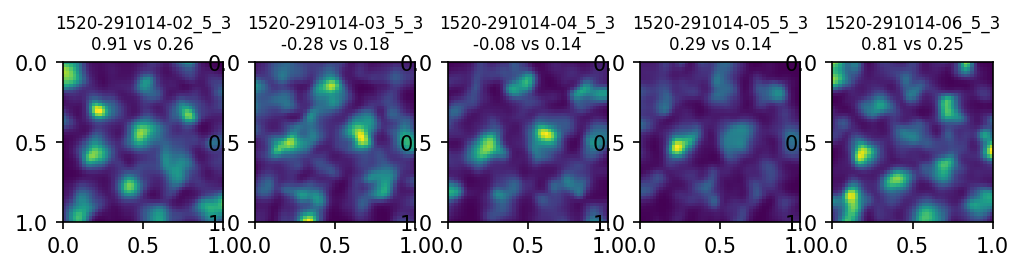

Plotting (1520, 5, 5) chABC True
Session count 1 1 1 1 1


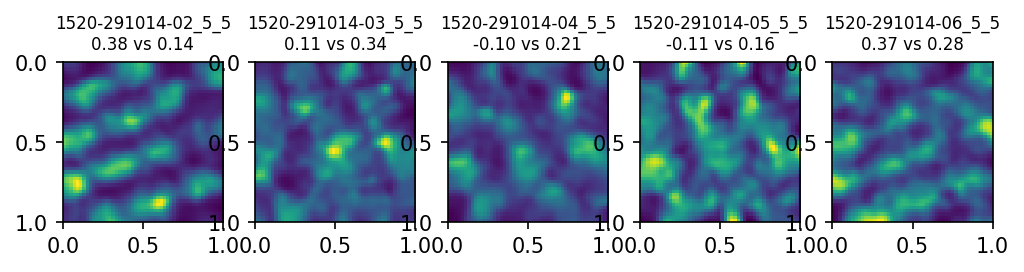

Plotting (1520, 5, 7) chABC True
Session count 1 1 1 1 1


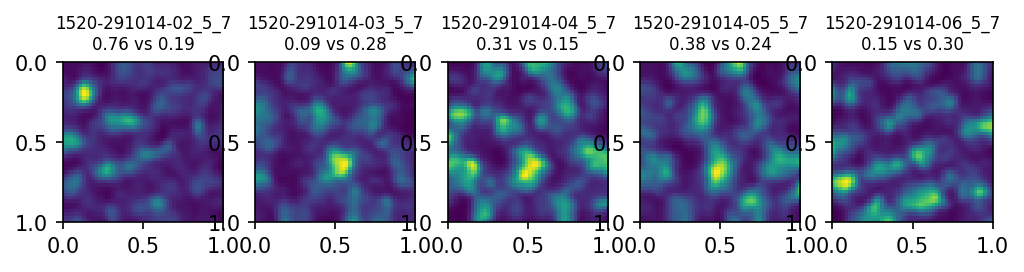

Plotting (1520, 5, 9) chABC True
Session count 1 1 1 1 1


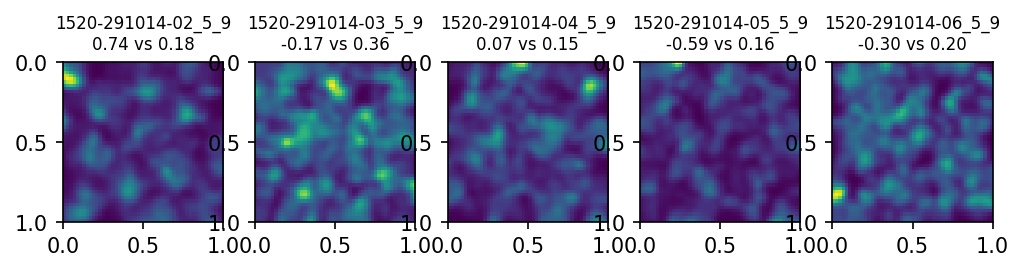

Plotting (1522, 5, 0) chABC True
Session count 1 1 1 1 1


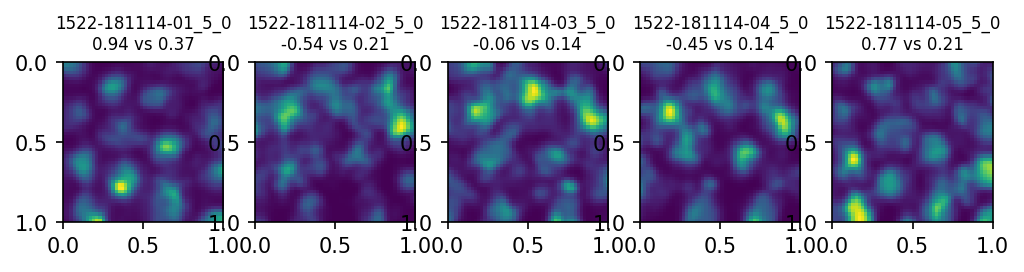

Plotting (1522, 5, 2) chABC True
Session count 1 1 1 1 1


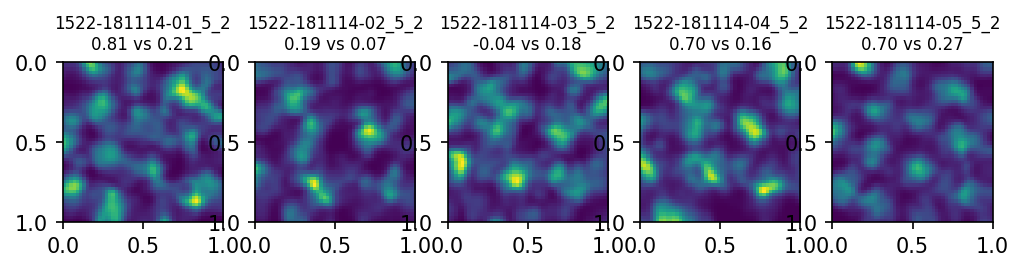

Plotting (1526, 6, 0) chABC True
Session count 1 1 1 1 1


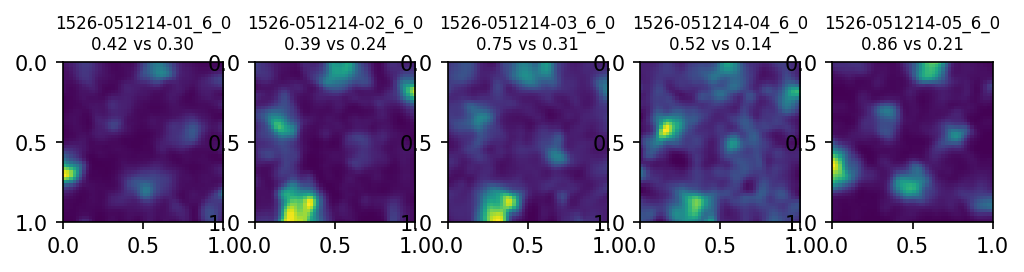

Plotting (1528, 1, 0) chABC False
Session count 1 1 1 1 1


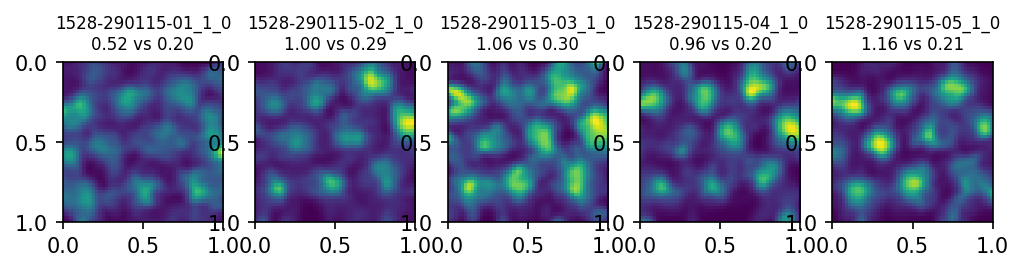

Plotting (1528, 2, 0) chABC False
Session count 1 1 1 1 1


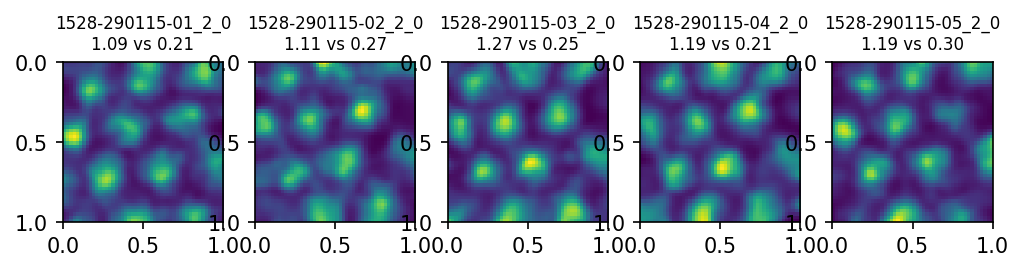

Plotting (1528, 2, 1) chABC False
Session count 1 1 1 1 1


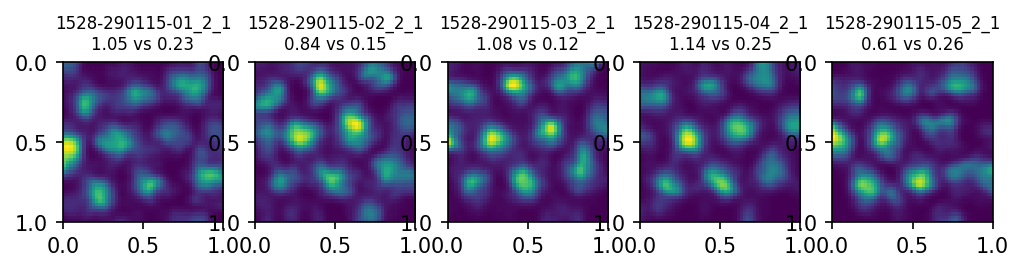

Plotting (1528, 2, 2) chABC False
Session count 1 1 1 1 1


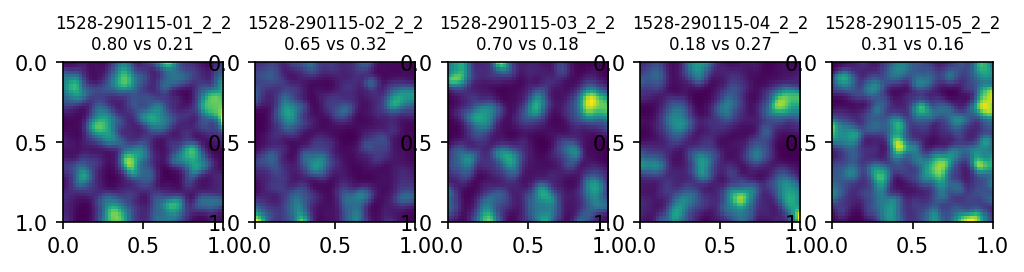

Plotting (1528, 2, 4) chABC False
Session count 1 1 1 1 1


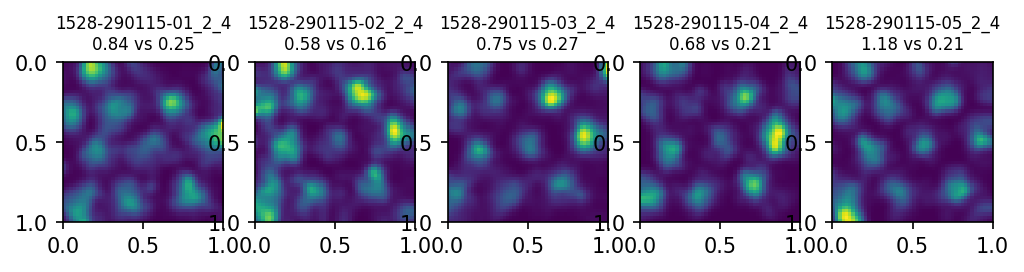

Plotting (1528, 3, 1) chABC False
Session count 1 1 1 1 1


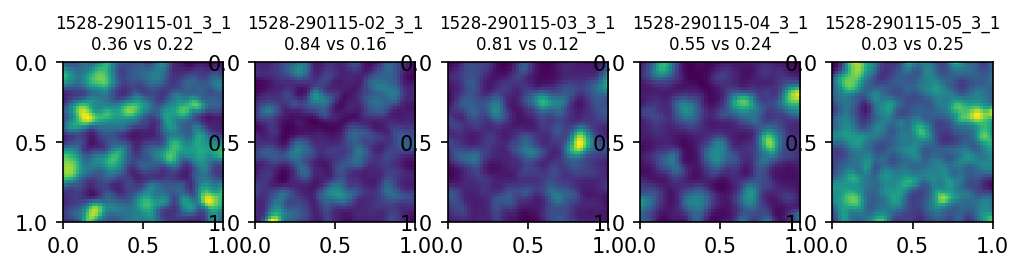

Plotting (1529, 3, 2) chABC False
Session count 1 1 1 1 1


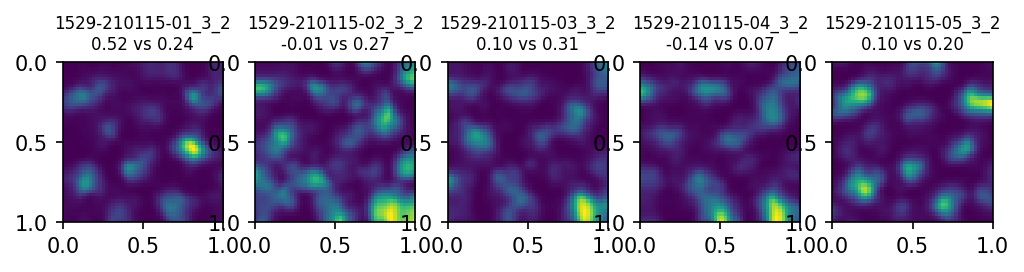

Plotting (1529, 3, 10) chABC False
Session count 1 1 1 1 1


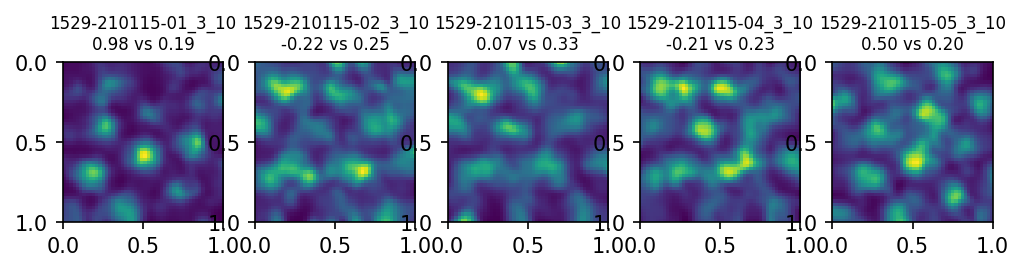

Plotting (1529, 5, 0) chABC False
Session count 1 1 1 1 1


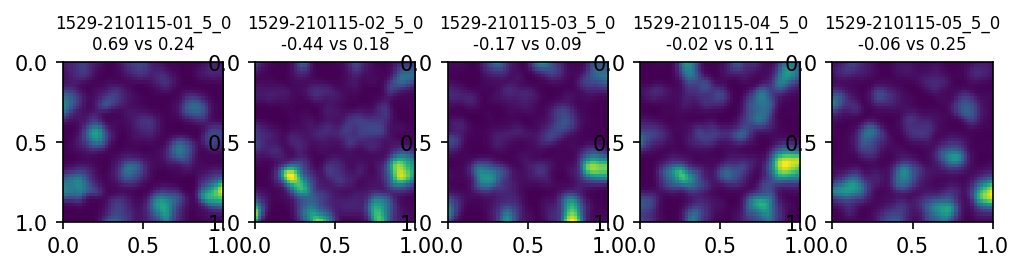

Plotting (1529, 5, 2) chABC False
Session count 1 1 1 1 1


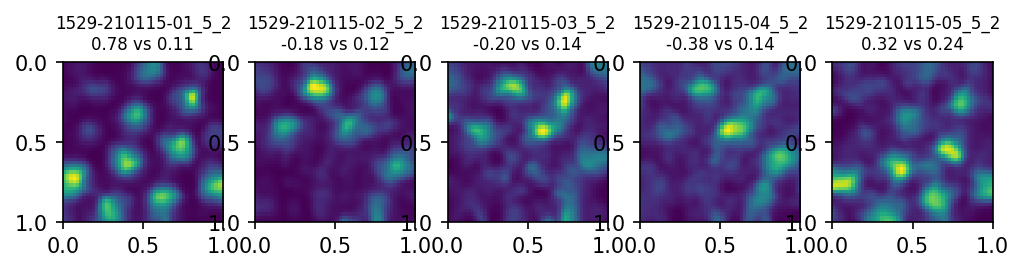

Plotting (1626, 5, 0) chABC True
Session count 1 1 1 0 1
Skipping
Plotting (1626, 5, 1) chABC True
Session count 1 1 0 0 0
Skipping
Plotting (1626, 5, 2) chABC True
Session count 1 1 1 0 0
Skipping
Plotting (1626, 5, 3) chABC True
Session count 1 1 1 0 1
Skipping
Plotting (1626, 6, 0) chABC True
Session count 1 1 1 1 1


/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/maps.py:87: RuntimeWarning: divide by zero encountered in true_divide
  rate_map = spike_map / occupancy_map


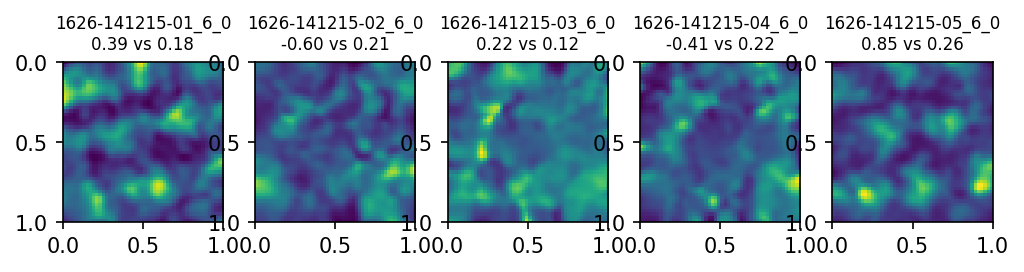

Plotting (1627, 0, 0) chABC True
Session count 1 1 1 1 1


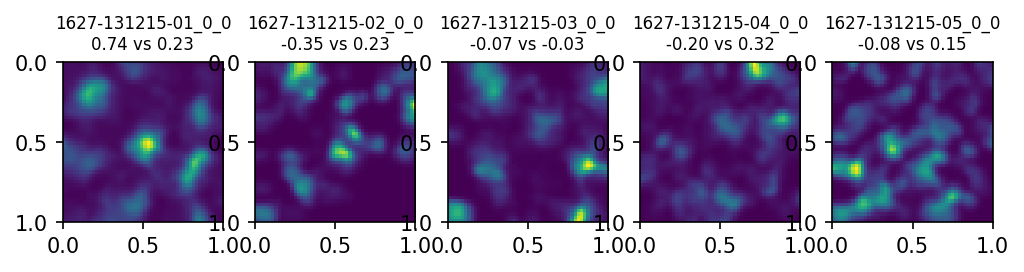

Plotting (1627, 0, 1) chABC True
Session count 1 1 1 1 1


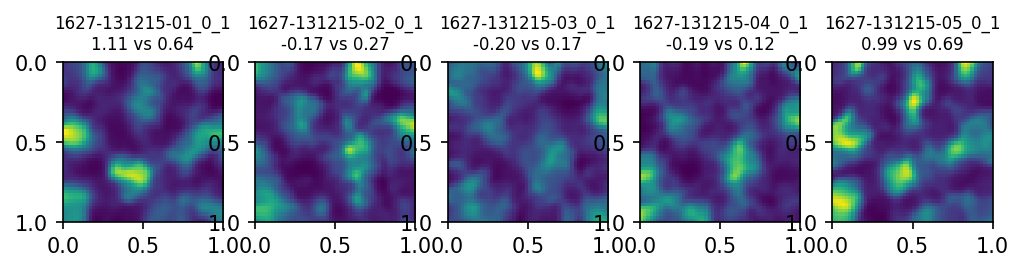

Plotting (1627, 0, 4) chABC True
Session count 1 0 0 0 1
Skipping
Plotting (1627, 1, 0) chABC True
Session count 1 1 1 1 1


/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/maps.py:87: RuntimeWarning: invalid value encountered in true_divide
  rate_map = spike_map / occupancy_map


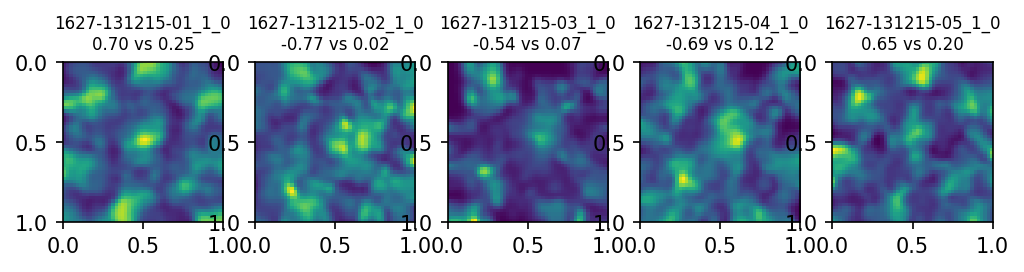

Plotting (1627, 1, 2) chABC True
Session count 1 1 1 1 1


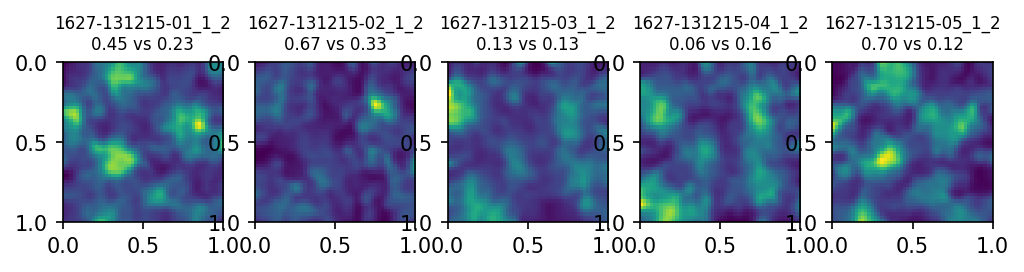

Plotting (1677, 7, 0) chABC True
Session count 1 1 1 1 1


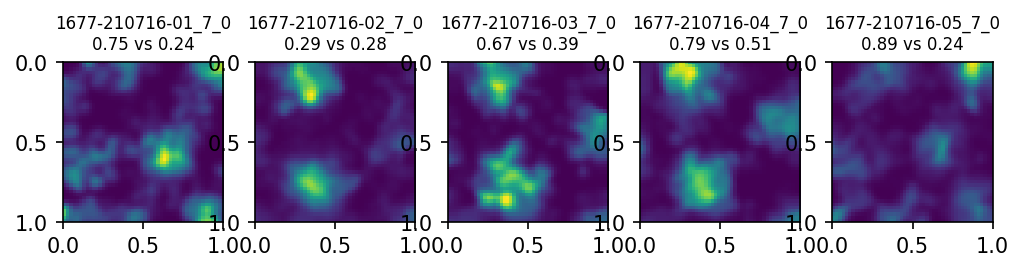

Plotting (1677, 7, 1) chABC True
Session count 1 1 1 1 1


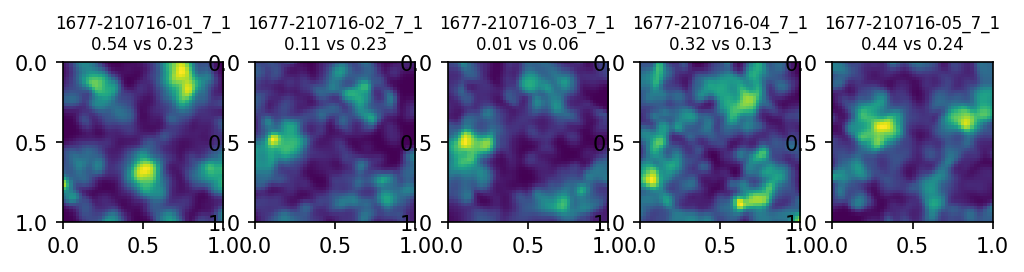

Plotting (1677, 7, 2) chABC True
Session count 1 0 0 0 0
Skipping
Plotting (1677, 7, 3) chABC True
Session count 1 0 0 0 0
Skipping
Plotting (1677, 7, 7) chABC True
Session count 1 1 1 0 1
Skipping
Plotting (1677, 7, 9) chABC True
Session count 1 1 1 1 1


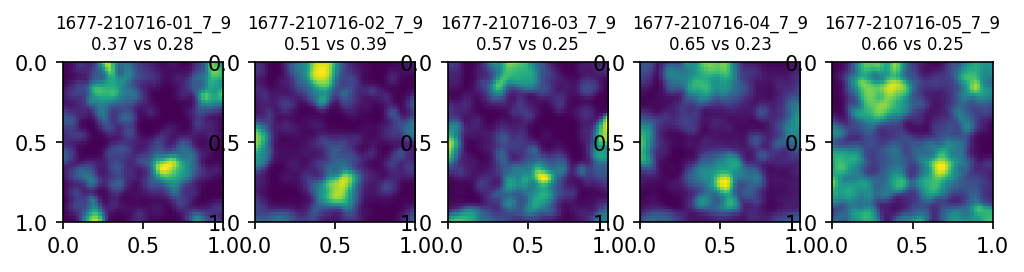

Plotting (1678, 7, 0) chABC True
Session count 1 1 1 1 0
Skipping
Plotting (1678, 7, 2) chABC True
Session count 1 1 1 1 1


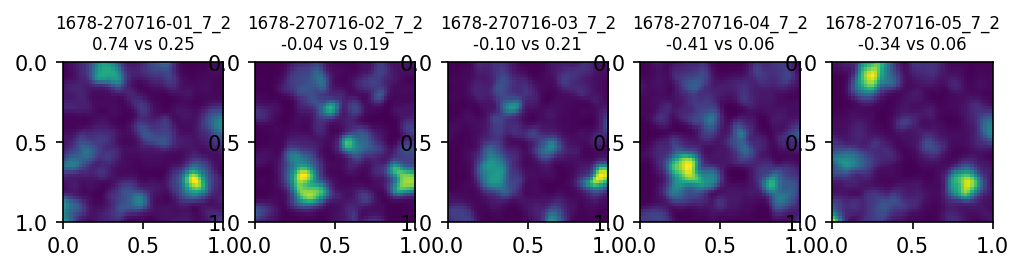

Plotting (1751, 2, 2) chABC False
Session count 1 0 0 0 0
Skipping
Plotting (1751, 3, 0) chABC False
Session count 1 0 0 0 0
Skipping
Plotting (1751, 3, 1) chABC False
Session count 1 0 0 0 1
Skipping
Plotting (1751, 5, 0) chABC False
Session count 1 0 0 0 0
Skipping
Plotting (1753, 1, 1) chABC False
Session count 1 0 0 0 0
Skipping
Plotting (1753, 4, 0) chABC False
Session count 1 1 1 1 1


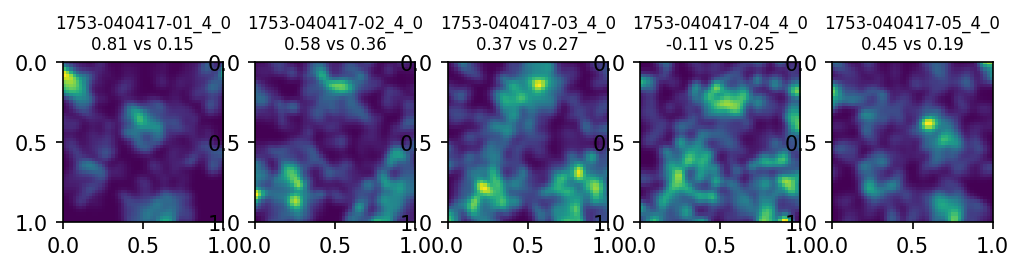

Plotting (1753, 4, 1) chABC False
Session count 1 1 1 1 1


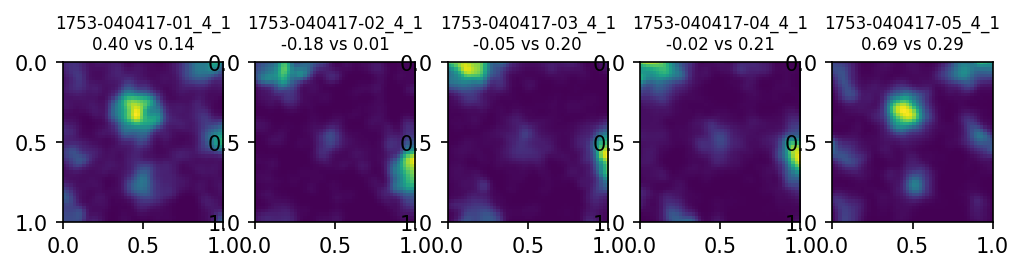

Plotting (1753, 4, 3) chABC False
Session count 1 1 1 1 1


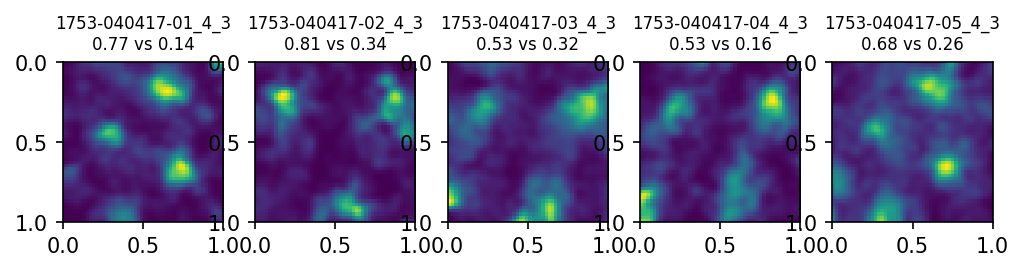

Plotting (1753, 7, 1) chABC False
Session count 1 1 1 1 1


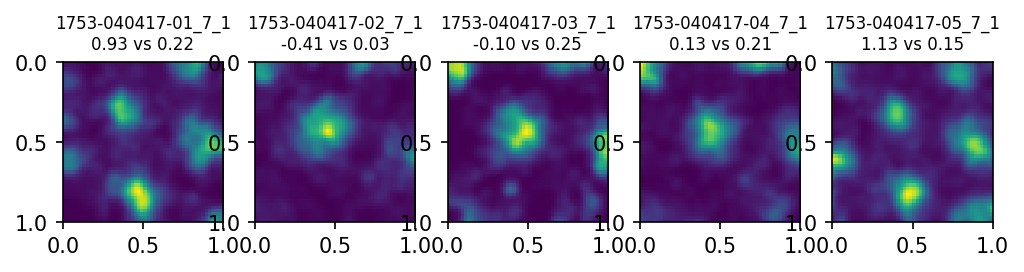

Plotting (1753, 7, 2) chABC False
Session count 1 1 1 1 1


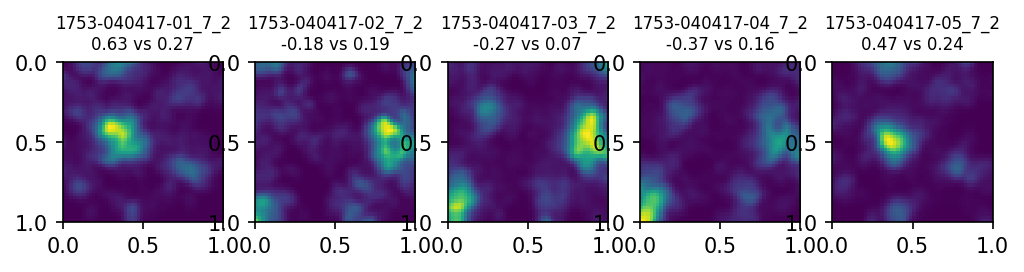

Plotting (1753, 7, 3) chABC False
Session count 1 1 1 1 1


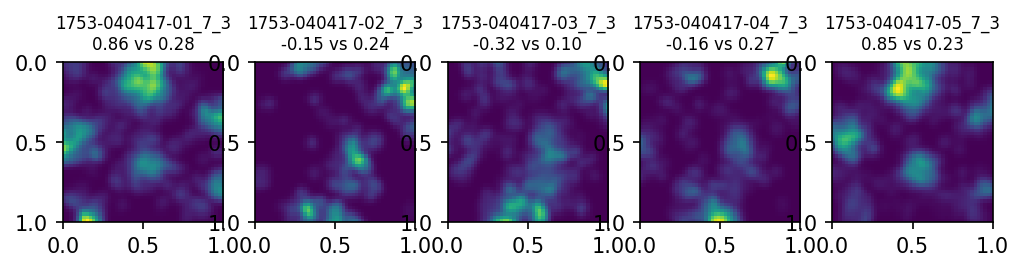

In [13]:
results = []

for name, group in grid_cell_sessions.groupby(cell_columns):
    print("Plotting", name, "chABC", group['chabc'].max())
    animal, channel, unit = name
    
    familiar_i = group.query('familiar and i and day1')
    novel_i = group.query('not familiar and i and day1')
    novel_ii = group.query('not familiar and ii and day1')
    novel_iii = group.query('not familiar and iii and day1')
    familiar_ii = group.query('familiar and ii and day1')
    
    print("Session count", len(familiar_i), len(novel_i), len(novel_ii), len(novel_iii), len(familiar_ii))
    
    if (len(familiar_ii) == 0 or len(novel_i) + len(novel_ii) == 0) or len(novel_iii) == 0 or len(familiar_i) == 0:
        print("Skipping")
        continue
    
    reference = create_rate_map(novel_iii.iloc[0], 0, 20*60)
    
    novel_parts = [
        (novel_i, 0, 5*60),
        (novel_i, 5*60, 10*60),
        (novel_ii, 10*60, 15*60),
        (novel_ii, 15*60, 20*60),
        (novel_ii, 0, 5*60),
        (novel_ii, 5*60, 10*60),
        (novel_ii, 10*60, 15*60),
        (novel_ii, 15*60, 20*60)
    ]
    
    sessions = [familiar_i, novel_i, novel_ii, novel_iii, familiar_ii]
    
    session_corrs = []
    plt.figure(figsize=(8, 3))
    for i, session in enumerate(sessions):
        if len(session) == 0:
            session_corrs.append(np.nan)
            continue
            
        sess = session.iloc[0]
        rate_map = create_rate_map(sess, 0, 20*60)
        
        plt.subplot(1, 5, i + 1)
        plt.title("{}_{}_{}\n{:.2f} vs {:.2f}".format(sess['action'], sess['channel'], 
                                                      sess['unit'], sess['gridness'],
                                                      sess['gridness_threshold']),
                 fontsize=8)
        
        plt.imshow(rate_map, extent=[0, 1, 1, 0])
        
        # first half vs second half
        first_rate_map = create_rate_map(sess, 0, 10*60)
        second_rate_map = create_rate_map(sess, 10*60, 20*60)
        
        corr = correlate(first_rate_map, second_rate_map)
        session_corrs.append(corr)
    
    # calculate correlation for novel parts
    novel_corrs = []
    for i, (session, tmin, tmax) in enumerate(novel_parts):
        if len(session) == 0:
            novel_corrs.append(np.nan)
            continue
            
        sess = session.iloc[0]
        rate_map = create_rate_map(sess, tmin, tmax)
        
        # TODO maybe create masked rate map?
        corr = correlate(rate_map, reference)
        novel_corrs.append(corr)
        
    familiar_i_rate_map = create_rate_map(familiar_i.iloc[0], 0, 20*60)
    familiar_ii_rate_map = create_rate_map(familiar_ii.iloc[0], 0, 20*60)
    familiar_i_vs_familiar_ii = correlate(familiar_i_rate_map, familiar_ii_rate_map)
        
    results.append({
        "animal": animal,
        "channel": channel,
        "unit": unit,
        "chabc": group['chabc'].max(),
        "session_corrs": np.array(session_corrs),
        "novel_corrs": np.array(novel_corrs),
        "familiar_i_first_vs_second": session_corrs[0],
        "familiar_ii_first_vs_second": session_corrs[-1],
        "novel_i_first_vs_second": session_corrs[1],
        "novel_ii_first_vs_second": session_corrs[2],
        "novel_iii_first_vs_second": session_corrs[3],
        "familiar_i_vs_familiar_ii": familiar_i_vs_familiar_ii,
    })
    
    plt.show()

results = pd.DataFrame(results)

In [14]:
results['diff_familiar_first_vs_second'] = results['familiar_ii_first_vs_second'] - results['familiar_i_first_vs_second']
results['diff_novel_i_familiar_i_first_vs_second'] = results['novel_i_first_vs_second'] - results['familiar_i_first_vs_second']

In [15]:
statistics_columns = ['familiar_i_first_vs_second',
                      'familiar_ii_first_vs_second',
                      'familiar_i_vs_familiar_ii',
                      'diff_familiar_first_vs_second',
                      'diff_novel_i_familiar_i_first_vs_second']

results.groupby('chabc')[statistics_columns].describe().T

chabc                                              False      True 
familiar_i_first_vs_second              count  16.000000  16.000000
                                        mean    0.657808   0.627356
                                        std     0.124337   0.121542
                                        min     0.394123   0.399395
                                        25%     0.599474   0.550332
                                        50%     0.670019   0.651283
                                        75%     0.742673   0.710592
                                        max     0.854536   0.807546
familiar_ii_first_vs_second             count  16.000000  16.000000
                                        mean    0.669488   0.507240
                                        std     0.171094   0.201244
                                        min     0.348148   0.011040
                                        25%     0.561979   0.408417
                                        50%     0.724704   0.532327
                                        75%     0.791675   0.607908
                                        max     0.900306   0.872702
familiar_i_vs_familiar_ii               count  16.000000  16.000000
                                        mean    0.630442   0.565515
                                        std     0.309128   0.303297
                                        min    -0.225223  -0.108043
                                        25%     0.564823   0.552704
                                        50%     0.764861   0.685022
                                        75%     0.830089   0.711883
                                        max     0.914667   0.855878
diff_familiar_first_vs_second           count  16.000000  16.000000
                                        mean    0.011680  -0.120116
                                        std     0.145799   0.182826
                                        min    -0.237234  -0.456239
                                        25%    -0.121766  -0.286473
                                        50%     0.017892  -0.114459
                                        75%     0.124905   0.033892
                                        max     0.254496   0.135705
diff_novel_i_familiar_i_first_vs_second count  16.000000  16.000000
                                        mean   -0.072256  -0.173611
                                        std     0.105641   0.218166
                                        min    -0.262599  -0.561581
                                        25%    -0.150556  -0.315311
                                        50%    -0.062926  -0.209430
                                        75%     0.010646  -0.041805
                                        max     0.093652   0.315342

In [16]:
scipy.stats.ranksums(results.query('chabc')['diff_novel_i_familiar_i_first_vs_second'],
                     results.query('not chabc')['diff_novel_i_familiar_i_first_vs_second'])

RanksumsResult(statistic=-1.8467569855388022, pvalue=0.06478236858142145)

In [17]:
scipy.stats.ranksums(results.query('chabc')['familiar_i_first_vs_second'],
                     results.query('chabc')['novel_i_first_vs_second'])

RanksumsResult(statistic=2.4497796746943297, pvalue=0.01429436517251196)

In [18]:
scipy.stats.ranksums(results.query('not chabc')['familiar_i_first_vs_second'],
                     results.query('not chabc')['novel_i_first_vs_second'])

RanksumsResult(statistic=1.733690231322141, pvalue=0.08297306072441268)

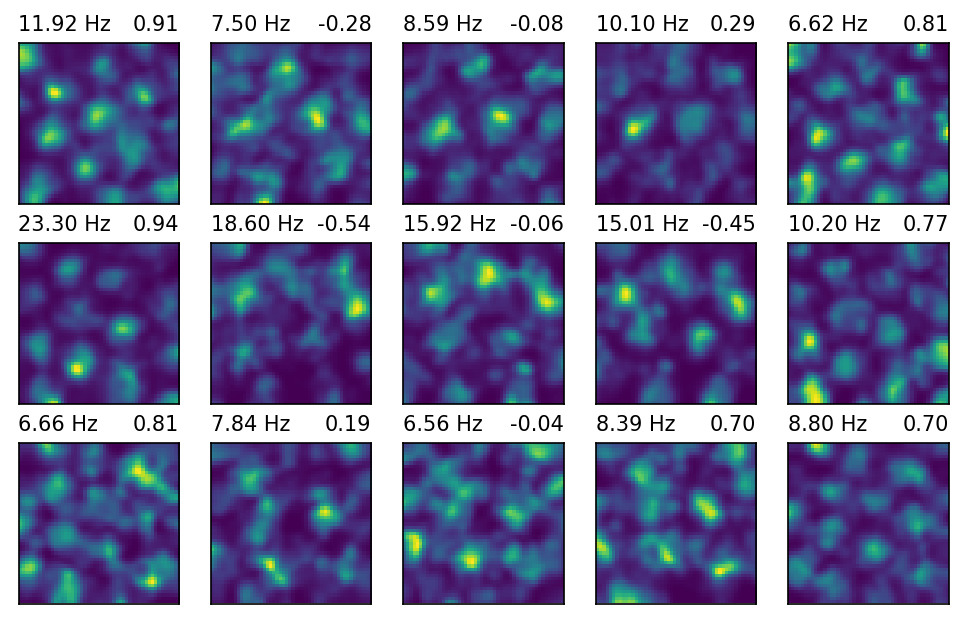

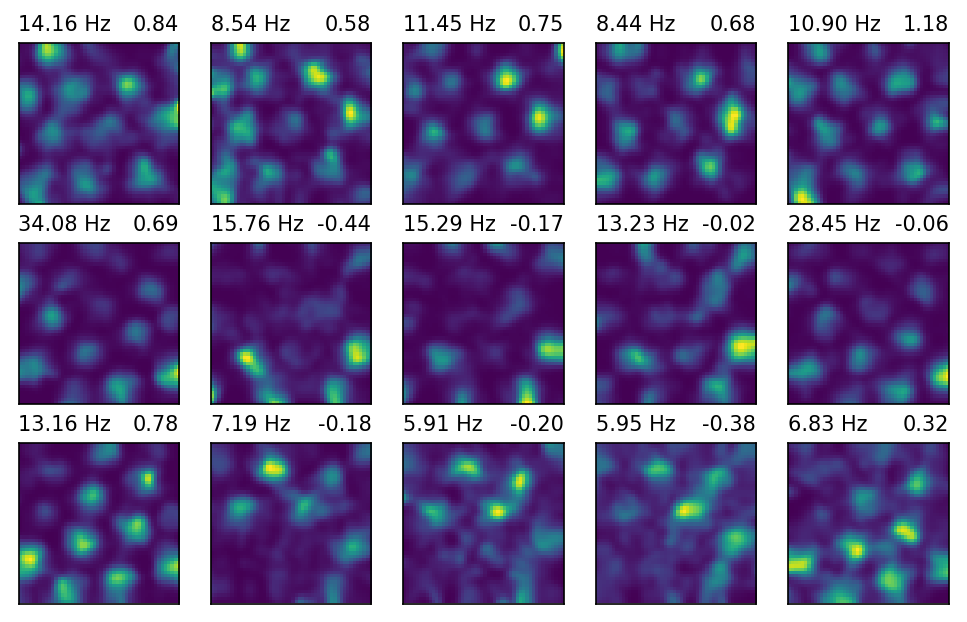

In [19]:

selection = {
    "chabc": [
         (1520, 5, 3),
         (1522, 5, 0),
         (1522, 5, 2),
    ],
    "control": [
         (1528, 2, 4),
         (1529, 5, 0),
         (1529, 5, 2),
    ]
}

for treatment, names in selection.items():
    plt.figure(figsize=(8, 5))
    for si, name in enumerate(names):
        action, channel, unit = name

        group = grid_cell_sessions.query('animal == {} and channel == {} and unit == {}'.format(action, channel, unit))

        familiar_i = group.query('familiar and i and day1')
        novel_i = group.query('not familiar and i and day1')
        novel_ii = group.query('not familiar and ii and day1')
        novel_iii = group.query('not familiar and iii and day1')
        familiar_ii = group.query('familiar and ii and day1')

        sessions = [familiar_i, novel_i, novel_ii, novel_iii, familiar_ii]

        for i, session in enumerate(sessions):
            if len(session) == 0:
                continue

            sess = session.iloc[0]
            rate_map = create_rate_map(sess, 0, 20*60)

            plt.subplot(len(names), 5, si * 5 + i + 1)
            plt.title("{:.2f} Hz".format(sess['max_rate']), loc='left', fontsize=10)
            plt.title("{:.2f}".format(sess['gridness']), loc='right', fontsize=10)
    #         plt.title("{}_{}_{}\n{:.2f} vs {:.2f}".format(sess['action'], sess['channel'], 
    #                                                       sess['unit'], sess['gridness'],
    #                                                       sess['gridness_threshold']))

            plt.xticks([])
            plt.yticks([])

            plt.imshow(rate_map, extent=[0, 1, 1, 0])

    plt.savefig(output_path / "figures" / "timeline_{}.pdf".format(treatment))
    plt.savefig(output_path / "figures" / "timeline_{}.png".format(treatment), dpi=600, transparent=True)

In [20]:
results.to_csv(output_path / "results.csv", index=False)

U test MannwhitneyuResult(statistic=4697.0, pvalue=3.273430430155184e-07)


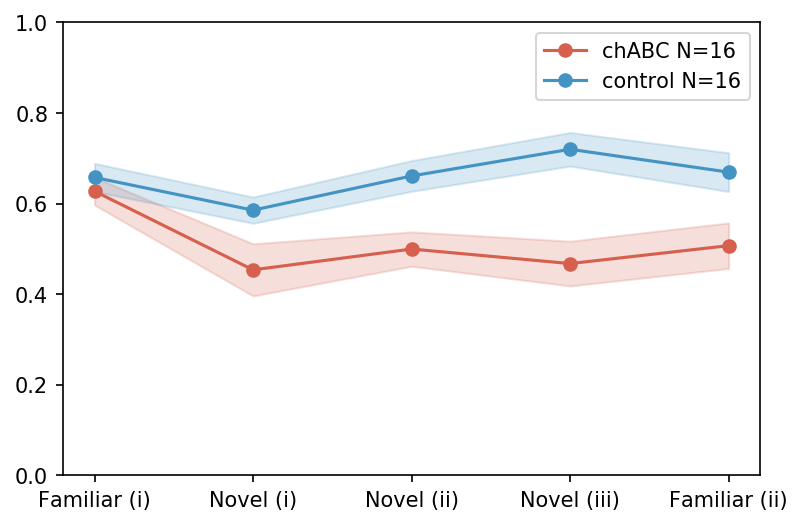

In [21]:
# np.stack is needed to convert array of arrays to 2D array
chabc = np.stack(results.query('chabc')['session_corrs'].to_numpy())
control = np.stack(results.query('not chabc')['session_corrs'].to_numpy())
    
print("U test", scipy.stats.mannwhitneyu(control.ravel(), chabc.ravel(),
                                             alternative='two-sided'))

t = np.array(["Familiar (i)", "Novel (i)", "Novel (ii)", "Novel (iii)", "Familiar (ii)"])

chabc_mean = np.nanmean(chabc, axis=0)
chabc_sem = scipy.stats.sem(chabc, axis=0, nan_policy='omit')
control_mean = np.nanmean(control, axis=0)
control_sem = scipy.stats.sem(control, axis=0, nan_policy='omit')

plt.plot(t, chabc_mean, 'o-', label='chABC N={}'.format(len(chabc)), color=chabc_color)
plt.fill_between(t, chabc_mean - chabc_sem, chabc_mean + chabc_sem, alpha=0.2, color=chabc_color)
# plt.errorbar(t, chabc.mean(axis=0), yerr=chabc.std(axis=0))
# plt.fill_between(t, chabc.mean() - chabc.std(),
#                     chabc.mean() + chabc.std())
plt.plot(t, control_mean, 'o-', label='control N={}'.format(len(control)), color=control_color)
plt.fill_between(t, control_mean - control_sem, control_mean + control_sem, alpha=0.2, color=control_color)
plt.ylim(0.0, 1.0)
# plt.errorbar(t, control.mean(axis=0), yerr=chabc.std(axis=0))
plt.legend()
    
plt.savefig(output_path / "figures" / "session_plot.pdf")
plt.savefig(output_path / "figures" / "session_plot.png", transparent=True)

U test MannwhitneyuResult(statistic=13022.0, pvalue=3.5479672676442045e-16)


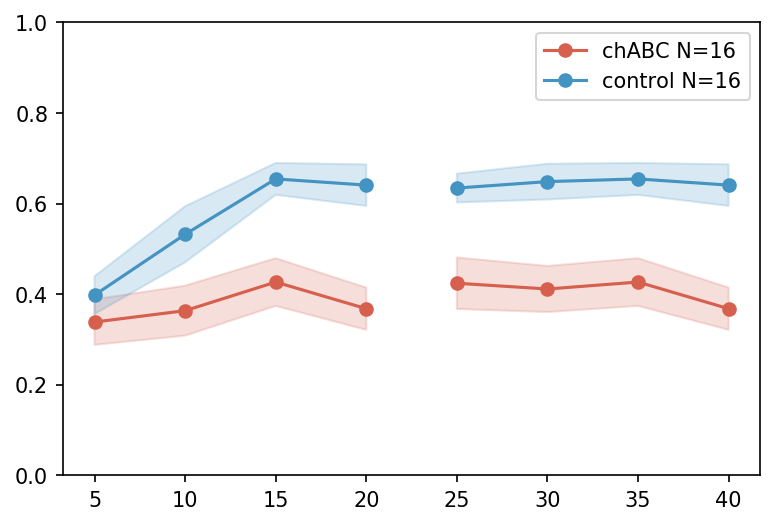

In [22]:
# np.stack is needed to convert array of arrays to 2D array
chabc = np.stack(results.query('chabc')['novel_corrs'].to_numpy())
control = np.stack(results.query('not chabc')['novel_corrs'].to_numpy())
    
print("U test", scipy.stats.mannwhitneyu(control.ravel(), chabc.ravel(),
                                             alternative='two-sided'))

t = np.array([5., 10., 15., 20., 25, 30, 35, 40])
t = np.insert(t, 4, np.nan)
chabc_mean = np.nanmean(chabc, axis=0)
chabc_sem = scipy.stats.sem(chabc, axis=0, nan_policy='omit')
chabc_mean = np.insert(chabc_mean, 4, np.nan)
chabc_sem = np.insert(chabc_sem, 4, np.nan)
control_mean = np.nanmean(control, axis=0)
control_sem = scipy.stats.sem(control, axis=0, nan_policy='omit')
control_mean = np.insert(control_mean, 4, np.nan)
control_sem = np.insert(control_sem, 4, np.nan)

plt.plot(t, chabc_mean, 'o-', label='chABC N={}'.format(len(chabc)), color=chabc_color)
plt.fill_between(t, chabc_mean - chabc_sem, chabc_mean + chabc_sem, alpha=0.2, color=chabc_color)
# plt.errorbar(t, chabc.mean(axis=0), yerr=chabc.std(axis=0))
# plt.fill_between(t, chabc.mean() - chabc.std(),
#                     chabc.mean() + chabc.std())
plt.plot(t, control_mean, 'o-', label='control N={}'.format(len(control)), color=control_color)
plt.fill_between(t, control_mean - control_sem, control_mean + control_sem, alpha=0.2, color=control_color)
plt.ylim(0, 1)
# plt.errorbar(t, control.mean(axis=0), yerr=chabc.std(axis=0))
plt.legend()
    

plt.savefig(output_path / "figures" / "time_plot.pdf")
plt.savefig(output_path / "figures" / "time_plot.png")

U test MannwhitneyuResult(statistic=4697.0, pvalue=3.273430430155184e-07)


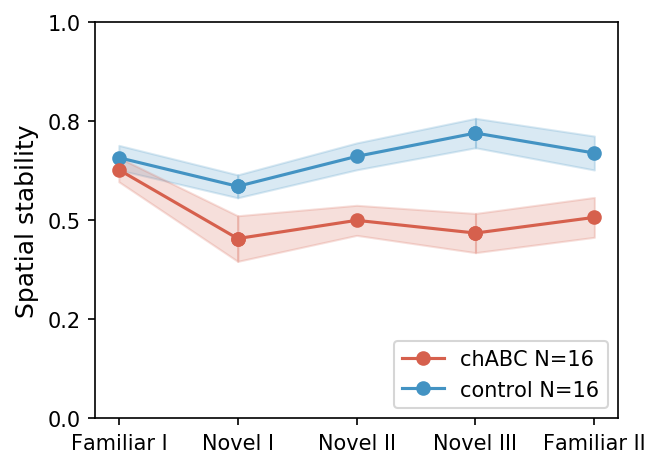

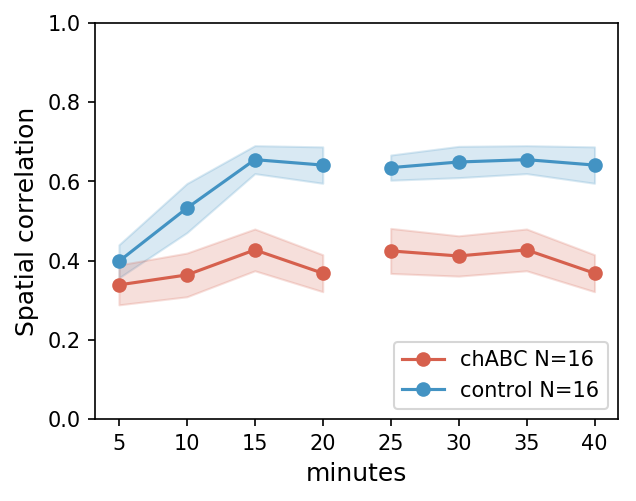

In [23]:
import mpl_toolkits.axes_grid1.inset_locator as inloc

# np.stack is needed to convert array of arrays to 2D array
chabc = np.stack(results.query('chabc')['session_corrs'].to_numpy())
control = np.stack(results.query('not chabc')['session_corrs'].to_numpy())

def plot_part(t, ax, part, control_color, chabc_color):
    ax.plot(t[part], control_mean[part], 'o-',
            color=control_color)
    ax.fill_between(t[part], control_mean[part] - control_sem[part],
                    control_mean[part] + control_sem[part], alpha=0.2, 
                    color=control_color)
    
    ax.plot(t[part], chabc_mean[part], 'o-',
            color=chabc_color)
    ax.fill_between(t[part], chabc_mean[part] - chabc_sem[part],
                    chabc_mean[part] + chabc_sem[part], alpha=0.2, 
                    color=chabc_color)

    
print("U test", scipy.stats.mannwhitneyu(control.ravel(), chabc.ravel(),
                                             alternative='two-sided'))

t = np.array(["Familiar I", "Novel I", "Novel II", "Novel III", "Familiar II"])

chabc_mean = np.nanmean(chabc, axis=0)
chabc_sem = scipy.stats.sem(chabc, axis=0, nan_policy='omit')
control_mean = np.nanmean(control, axis=0)
control_sem = scipy.stats.sem(control, axis=0, nan_policy='omit')

plt.figure(figsize=(4.5, 3.5))

# Hack to make axes right order
plt.plot(t, -1.0 * np.ones(len(t)), 'o-', label='chABC N={}'.format(len(chabc)), color=chabc_novel_color)
plt.plot(t, -1.0 * np.ones(len(t)), 'o-', label='control N={}'.format(len(control)), color=control_novel_color)

ax = plt.gca()
plot_part(t, ax, slice(0, 2), control_color, chabc_color)
plot_part(t, ax, slice(3, 6), control_color, chabc_color)
plot_part(t, ax, slice(1, 4), control_novel_color, chabc_novel_color)

ticks = np.linspace(0, 1.0, 5)
ax.set_yticks(ticks)
ax.set_yticklabels(np.round(ticks, 1))

ax.set_ylim(0.0, 1.0)
ax.legend(loc=4)
ax.set_ylabel("Spatial stability", fontsize=12)

novel_chabc = np.stack(results.query('chabc')['novel_corrs'].to_numpy())
novel_control = np.stack(results.query('not chabc')['novel_corrs'].to_numpy())

t = np.array([5., 10., 15., 20., 25, 30, 35, 40])
t = np.insert(t, 4, np.nan)
chabc_mean = np.nanmean(novel_chabc, axis=0)
chabc_sem = scipy.stats.sem(novel_chabc, axis=0, nan_policy='omit')
chabc_mean = np.insert(chabc_mean, 4, np.nan)
chabc_sem = np.insert(chabc_sem, 4, np.nan)
control_mean = np.nanmean(novel_control, axis=0)
control_sem = scipy.stats.sem(novel_control, axis=0, nan_policy='omit')
control_mean = np.insert(control_mean, 4, np.nan)
control_sem = np.insert(control_sem, 4, np.nan)
plt.savefig(output_path / "figures" / "spatial_stability_over_time.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "spatial_stability_over_time.png", bbox_inches='tight', transparent=True)

plt.figure(figsize=(4.5, 3.5))
ax1 = plt.gca()
# ax1.set_title("Novel (i) and (ii) vs (iii)")
ax1.set_xlabel("minutes", fontsize=12)
ax1.set_ylabel("Spatial correlation", fontsize=12)
ax1.set_ylim(0.0, 1.0)

plot_part(t, ax1, slice(0, 4), control_novel_color, chabc_novel_color)
plot_part(t, ax1, slice(5, 9), control_novel_color, chabc_novel_color)
plt.plot(t, -1.0 * np.ones(len(t)), 'o-', label='chABC N={}'.format(len(chabc)), color=chabc_novel_color)
plt.plot(t, -1.0 * np.ones(len(t)), 'o-', label='control N={}'.format(len(control)), color=control_novel_color)
ax1.legend(loc=4)

plt.savefig(output_path / "figures" / "spatial_correlation_over_time.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "spatial_correlation_over_time.png", bbox_inches='tight', transparent=True)

In [24]:
# TODO we could do this when we create the initial results instead of unwrapping it here

all_corrs = []

for index, row in results.iterrows():
    corrs = row['novel_corrs']
    for corr in corrs:
        all_corrs.append({
            'chabc': row['chabc'],
            'corr': corr
        })
        
all_corrs = pd.DataFrame(all_corrs)

In [25]:
def plot_significance(pvalue, y, h):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = [0, 1]
    data_max = np.max([control.max(), chabc.max()])
    data_min = np.min([control.min(), chabc.min()])
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')


Z = -8.15382192491471 p = 3.5259994949270506e-16 nchabc = 128 ncontrol = 128
ChABC: 0.39096830624776624 +/- 0.2032264991097676
Control: 0.6004917939233041 +/- 0.18814626472626964


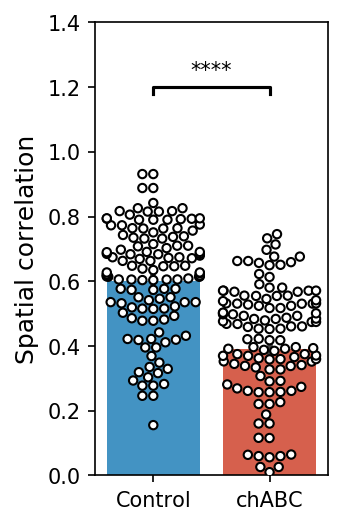

In [26]:
plt.figure(figsize=(2, 4))

ax = sns.barplot('chabc', 'corr', data=all_corrs, 
                 palette=[control_novel_color, chabc_novel_color], 
                 saturation=1)
sns.swarmplot('chabc', 'corr', data=all_corrs, edgecolor='black', linewidth=1, color="white", size=4.0)
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial correlation", fontsize=12)
ax.set_xlabel("")

chabc = all_corrs.query('chabc')
control = all_corrs.query('not chabc')

Zvalue, pvalue = scipy.stats.ranksums(chabc['corr'],
                                      control['corr'])
print("Z = {Z} p = {p} nchabc = {nchabc} ncontrol = {ncontrol}".format(Z=Zvalue, p=pvalue, 
                                                                       nchabc=len(chabc), 
                                                                       ncontrol=len(control)))
print("ChABC: {mean} +/- {std}".format(mean=chabc['corr'].mean(),
                                      std=chabc['corr'].std()))
print("Control: {mean} +/- {std}".format(mean=control['corr'].mean(),
                                         std=control['corr'].std()))

plot_significance(pvalue, 1.2, 0.02)

plt.ylim(0, 1.4)

plt.savefig(output_path / "figures" / "novel_summarized.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "novel_summarized.png", bbox_inches='tight')

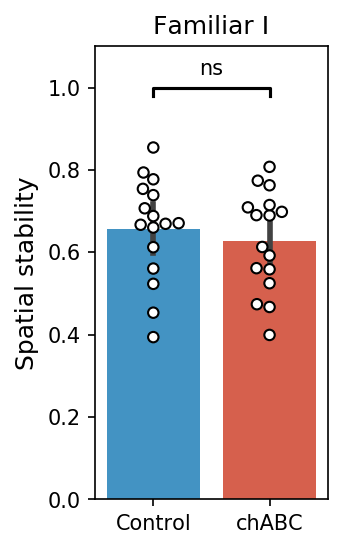

In [27]:
plt.figure(figsize=(2, 4))

plt.title("Familiar I")
ax = sns.barplot('chabc', 'familiar_i_first_vs_second', data=results, palette=[control_color, chabc_color], saturation=1)
sns.swarmplot('chabc', 'familiar_i_first_vs_second', data=results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial stability", fontsize=12)
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(results.query('chabc')['familiar_i_first_vs_second'],
                                      results.query('not chabc')['familiar_i_first_vs_second'])

plot_significance(pvalue, 1.0, 0.02)

plt.ylim(0, 1.1)

plt.savefig(output_path / "figures" / "familiar_i_stability.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "familiar_i_stability.png", bbox_inches='tight')

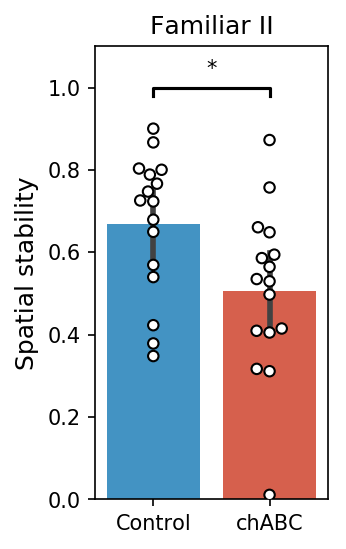

In [28]:
plt.figure(figsize=(2, 4))

plt.title("Familiar II")
ax = sns.barplot('chabc', 'familiar_ii_first_vs_second', data=results, palette=[control_color, chabc_color], saturation=1)
sns.swarmplot('chabc', 'familiar_ii_first_vs_second', data=results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial stability", fontsize=12)
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(results.query('chabc')['familiar_ii_first_vs_second'],
                                      results.query('not chabc')['familiar_ii_first_vs_second'])

plot_significance(pvalue, 1.0, 0.02)

plt.ylim(0, 1.1)

plt.savefig(output_path / "figures" / "familiar_ii_stability.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "familiar_ii_stability.png", bbox_inches='tight')

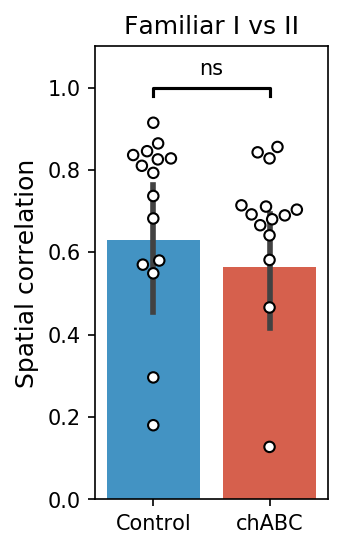

In [29]:
plt.figure(figsize=(2, 4))

plt.title("Familiar I vs II")
ax = sns.barplot('chabc', 'familiar_i_vs_familiar_ii', data=results, palette=[control_color, chabc_color], saturation=1)
sns.swarmplot('chabc', 'familiar_i_vs_familiar_ii', data=results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial correlation", fontsize=12)
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(results.query('chabc')['familiar_i_vs_familiar_ii'],
                                      results.query('not chabc')['familiar_i_vs_familiar_ii'])

plot_significance(pvalue, 1.0, 0.02)

plt.ylim(0, 1.1)

plt.savefig(output_path / "figures" / "familiar_i_vs_ii.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "familiar_i_vs_ii.png", bbox_inches='tight')

-1.8844459036110226 0.05950468564042985


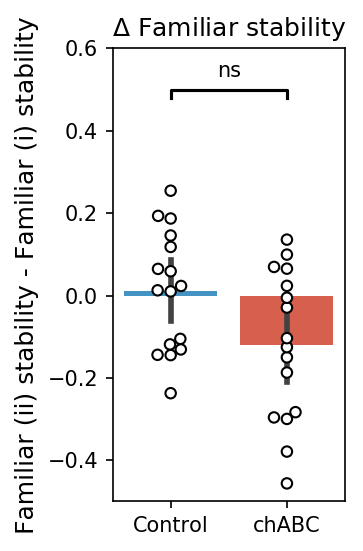

In [30]:
plt.figure(figsize=(2, 4))

plt.title("$\Delta$ Familiar stability")
ax = sns.barplot('chabc', 'diff_familiar_first_vs_second', data=results, palette=[control_color, chabc_color], saturation=1)
sns.swarmplot('chabc', 'diff_familiar_first_vs_second', data=results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Familiar (ii) stability - Familiar (i) stability", fontsize=12) 
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(results.query('chabc')['diff_familiar_first_vs_second'],
                                      results.query('not chabc')['diff_familiar_first_vs_second'])

print(Zvalue, pvalue)

plot_significance(pvalue, 0.5, 0.02)

plt.ylim(-0.5, 0.6)

plt.savefig(output_path / "figures" / "diff_familiar_stability.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "diff_familiar_stability.png", bbox_inches='tight')

# Novel across days

Plotting (1520, 5, 3) chABC True
Session count 1 1 1


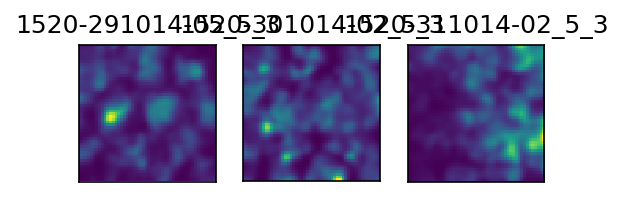

Plotting (1520, 5, 5) chABC True
Session count 1 0 0
Skipping
Plotting (1520, 5, 7) chABC True
Session count 1 1 1


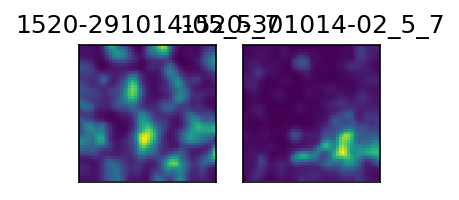

Plotting (1520, 5, 9) chABC True
Session count 1 0 0
Skipping
Plotting (1522, 5, 0) chABC True
Session count 1 1 1


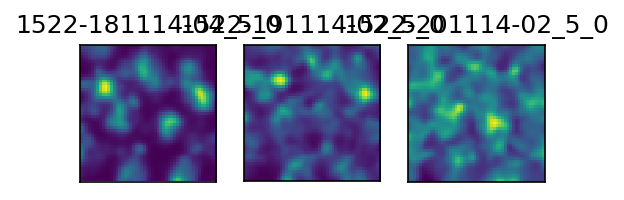

Plotting (1522, 5, 2) chABC True
Session count 1 1 1


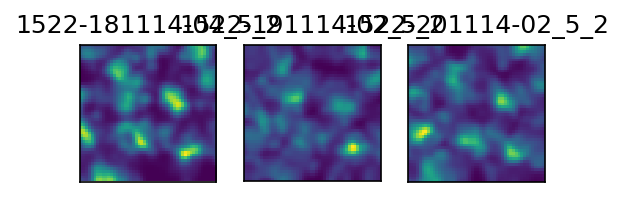

Plotting (1526, 6, 0) chABC True
Session count 1 0 0
Skipping
Plotting (1528, 1, 0) chABC False
Session count 1 0 0
Skipping
Plotting (1528, 2, 0) chABC False
Session count 1 1 1


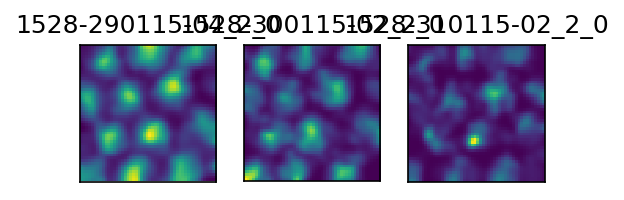

Plotting (1528, 2, 1) chABC False
Session count 1 1 1


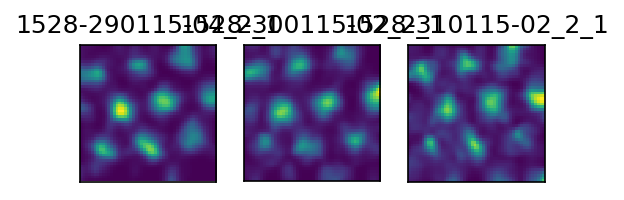

Plotting (1528, 2, 2) chABC False
Session count 1 1 1


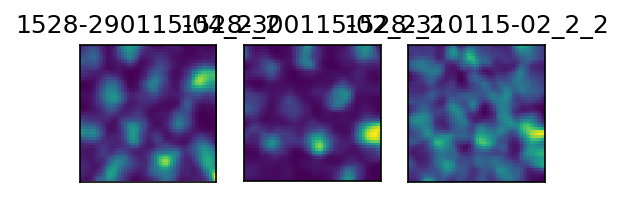

Plotting (1528, 2, 4) chABC False
Session count 1 1 1


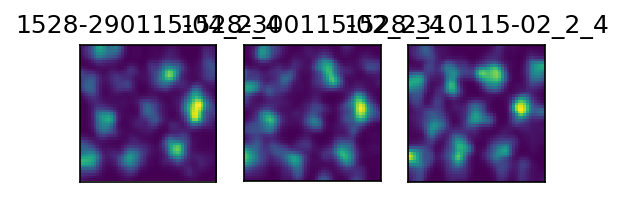

Plotting (1528, 3, 1) chABC False
Session count 1 0 0
Skipping
Plotting (1529, 3, 2) chABC False
Session count 1 1 1


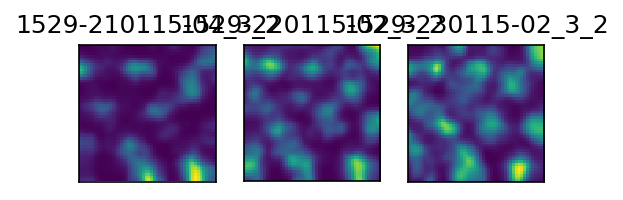

Plotting (1529, 3, 10) chABC False
Session count 1 1 1


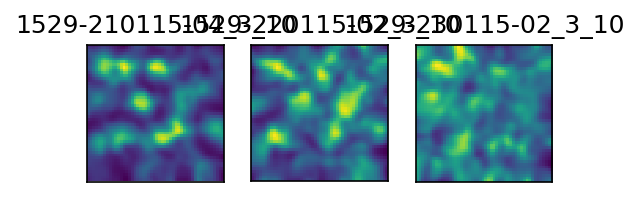

Plotting (1529, 5, 0) chABC False
Session count 1 0 0
Skipping
Plotting (1529, 5, 2) chABC False
Session count 1 0 0
Skipping
Plotting (1626, 5, 0) chABC True
Session count 0 0 0
Skipping
Plotting (1626, 5, 1) chABC True
Session count 0 0 0
Skipping
Plotting (1626, 5, 2) chABC True
Session count 0 0 0
Skipping
Plotting (1626, 5, 3) chABC True
Session count 0 0 0
Skipping
Plotting (1626, 6, 0) chABC True
Session count 1 1 1


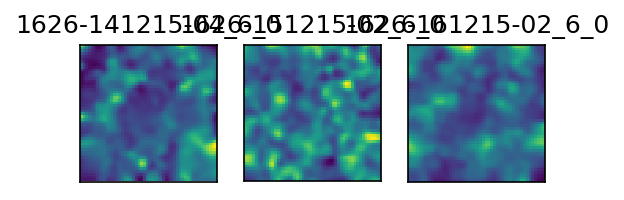

Plotting (1627, 0, 0) chABC True
Session count 1 1 1


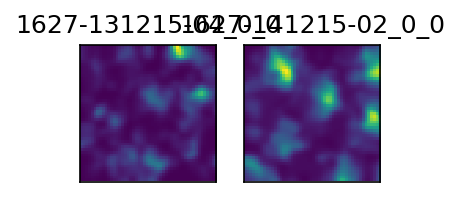

Plotting (1627, 0, 1) chABC True
Session count 1 1 1


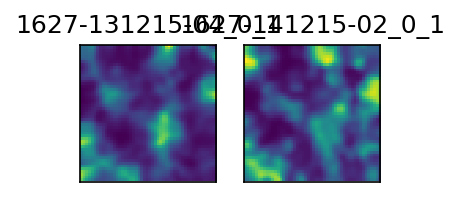

Plotting (1627, 0, 4) chABC True
Session count 0 0 0
Skipping
Plotting (1627, 1, 0) chABC True
Session count 1 1 1


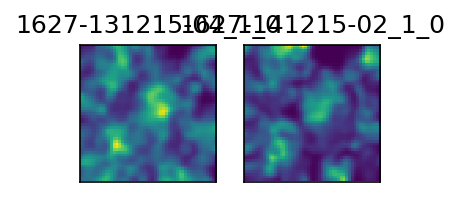

Plotting (1627, 1, 2) chABC True
Session count 1 1 1


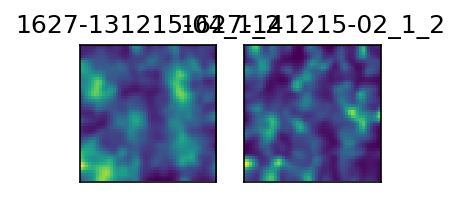

Plotting (1677, 7, 0) chABC True
Session count 1 0 0
Skipping
Plotting (1677, 7, 1) chABC True
Session count 1 0 0
Skipping
Plotting (1677, 7, 2) chABC True
Session count 0 0 0
Skipping
Plotting (1677, 7, 3) chABC True
Session count 0 0 0
Skipping
Plotting (1677, 7, 7) chABC True
Session count 0 0 0
Skipping
Plotting (1677, 7, 9) chABC True
Session count 1 0 0
Skipping
Plotting (1678, 7, 0) chABC True
Session count 1 1 1


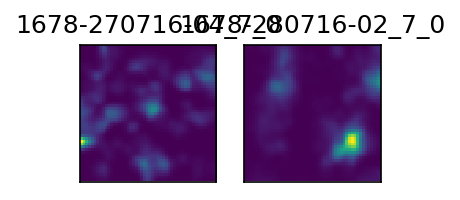

Plotting (1678, 7, 2) chABC True
Session count 1 1 1


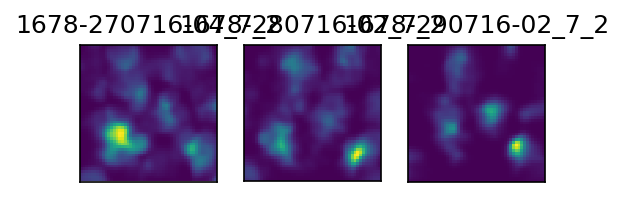

Plotting (1751, 2, 2) chABC False
Session count 0 0 0
Skipping
Plotting (1751, 3, 0) chABC False
Session count 0 0 0
Skipping
Plotting (1751, 3, 1) chABC False
Session count 0 0 0
Skipping
Plotting (1751, 5, 0) chABC False
Session count 0 1 1


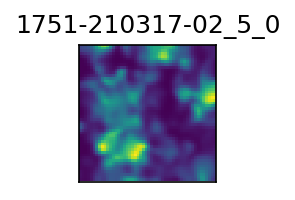

Plotting (1753, 1, 1) chABC False
Session count 0 0 0
Skipping
Plotting (1753, 4, 0) chABC False
Session count 1 1 1


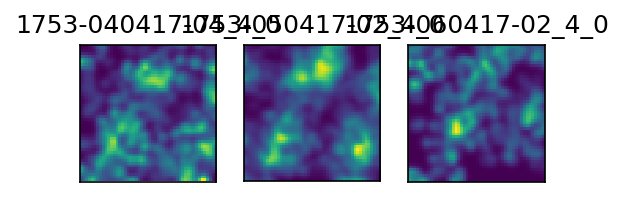

Plotting (1753, 4, 1) chABC False
Session count 1 1 1


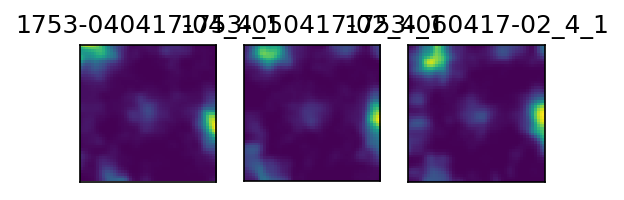

Plotting (1753, 4, 3) chABC False
Session count 1 1 1


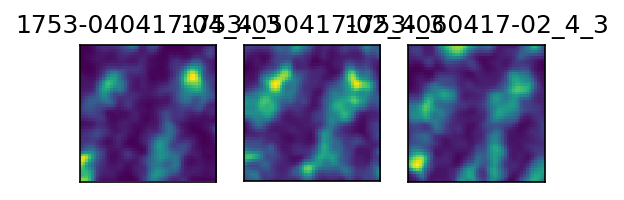

Plotting (1753, 7, 1) chABC False
Session count 1 1 1


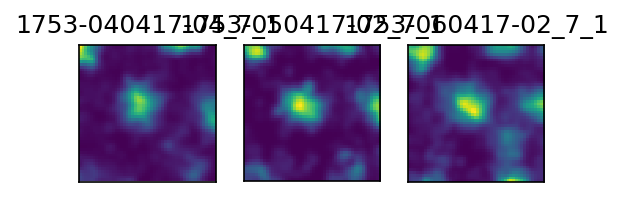

Plotting (1753, 7, 2) chABC False
Session count 1 1 1


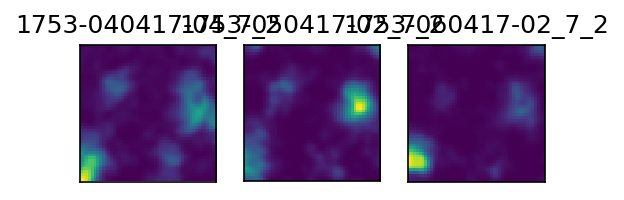

Plotting (1753, 7, 3) chABC False
Session count 1 1 1


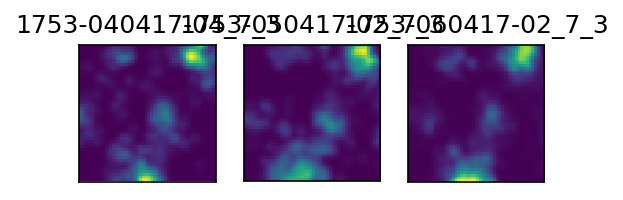

In [31]:
multiday_results = []

for name, group in grid_cell_sessions.groupby(cell_columns):
    print("Plotting", name, "chABC", group['chabc'].max())
    animal, channel, unit = name
    
    day_1 = group.query('not familiar and iii and day1')
    day_2 = group.query('not familiar and day2')
    day_3 = group.query('not familiar and day3')
    
    print("Session count", len(day_1), len(day_2), len(day_2))
    
    if (len(day_1) + len(day_2) == 0) or (len(day_2) + len(day_3) == 0):
        print("Skipping")
        continue
    
    comparisons = [("day1_vs_day2", day_1, day_2),
                   ("day2_vs_day3", day_2, day_3),
                   ("day1_vs_day3", day_1, day_3)]
    
    result = {
        "animal": animal,
        "channel": channel,
        "unit": unit,
        "chabc": group['chabc'].max(),
    }
    for i, (cname, day_a, day_b) in enumerate(comparisons):
        if len(day_a) == 0 or len(day_b) == 0:
            result[cname] = np.nan
            continue
            
        day_a = day_a.iloc[0]
        day_b = day_b.iloc[0]
        
        # first half vs second half
        first_rate_map = create_rate_map(day_a, 0, 20*60)
        second_rate_map = create_rate_map(day_b, 0, 20*60)
        
        correlation = correlate(first_rate_map, second_rate_map)
        
        result[cname] = correlation
       
    # Plot to show
    plt.figure(figsize=(4, 2))
    for i, session in enumerate([day_1, day_2, day_3]):
        if len(session) == 0:
            continue
        sess = session.iloc[0]
        
        rate_map = create_rate_map(sess, 0, 20*60)
       
        plt.subplot(1, 3, i + 1)
        plt.imshow(rate_map)
        plt.title("{}_{}_{}".format(sess['action'], sess['channel'], sess['unit']))
        plt.xticks([])
        plt.yticks([])
    
    multiday_results.append(result)
    plt.show()

multiday_results = pd.DataFrame(multiday_results)

In [32]:
multiday_results.to_csv(output_path / "multiday_results.csv", index=False)
multiday_results

,animal,chabc,channel,day1_vs_day2,day1_vs_day3,day2_vs_day3,unit
0,1520,True,5,0.408996,-0.102007,-0.079620,3
1,1520,True,5,0.087181,NaN,NaN,7
2,1522,True,5,0.543567,0.554367,0.379519,0
3,1522,True,5,0.643678,0.672231,0.543915,2
4,1528,False,2,0.751926,0.560688,0.643719,0
5,1528,False,2,0.813144,0.816107,0.835991,1
6,1528,False,2,-0.214869,0.130270,0.642858,2
7,1528,False,2,0.846192,0.727248,0.711611,4
8,1529,False,3,0.572044,0.501079,0.749471,2
9,1529,False,3,0.650001,0.249382,0.079694,10


# Plot selected multiday sessions

Plotting (1522, 5, 2) chABC True
Session count 1 1 1


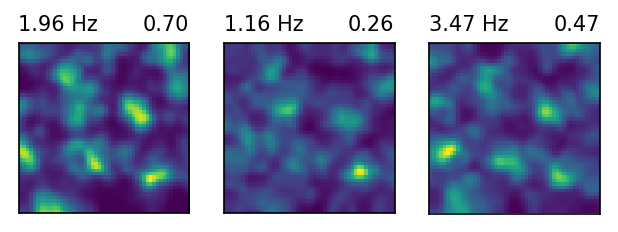

Plotting (1528, 2, 4) chABC False
Session count 1 1 1


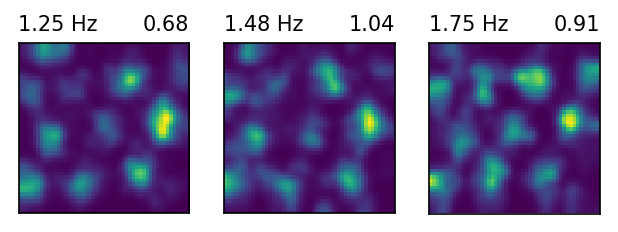

In [33]:
selection = {
    "chabc": [
         (1522, 5, 2),
    ],
    "control": [
         (1528, 2, 4),
    ]
}

for treatment, names in selection.items():
    plt.figure(figsize=(5, 5))
    for si, name in enumerate(names):
        action, channel, unit = name

        group = grid_cell_sessions.query('animal == {} and channel == {} and unit == {}'.format(action, channel, unit))
        
        print("Plotting", name, "chABC", group['chabc'].max())

        day_1 = group.query('not familiar and iii and day1')
        day_2 = group.query('not familiar and day2')
        day_3 = group.query('not familiar and day3')

        print("Session count", len(day_1), len(day_2), len(day_2))

        if (len(day_1) + len(day_2) == 0) or (len(day_2) + len(day_3) == 0):
            print("Skipping")
            continue

        # Plot to show
        for i, session in enumerate([day_1, day_2, day_3]):
            if len(session) == 0:
                continue
            sess = session.iloc[0]

            rate_map = create_rate_map(sess, 0, 20*60)

            plt.subplot(len(names), 3, si * 3 + i + 1)
            plt.imshow(rate_map)
            plt.title("{:.2f} Hz".format(sess['average_rate']), loc='left', fontsize=10)
            plt.title("{:.2f}".format(sess['gridness']), loc='right', fontsize=10)
            plt.xticks([])
            plt.yticks([])

    plt.savefig(output_path / "figures" / "multiday_{}.png".format(treatment), bbox_inches='tight', dpi=600, transparent=True)
    plt.savefig(output_path / "figures" / "multiday_{}.pdf".format(treatment), bbox_inches='tight')
    plt.show()

-3.041668662387186 0.002352707159580203


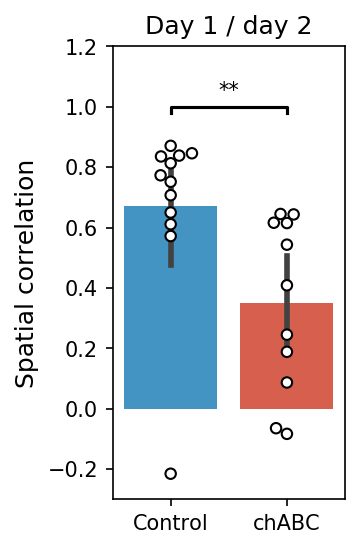

In [34]:
plt.figure(figsize=(2, 4))

plt.title("Day 1 / day 2")
ax = sns.barplot('chabc', 'day1_vs_day2', data=multiday_results, palette=[control_novel_color, chabc_novel_color], saturation=1)
sns.swarmplot('chabc', 'day1_vs_day2', data=multiday_results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial correlation", fontsize=12)
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(multiday_results.query('chabc')['day1_vs_day2'],
                                      multiday_results.query('not chabc')['day1_vs_day2'])

print(Zvalue, pvalue)
plot_significance(pvalue, 1.0, 0.02)

plt.ylim(-0.3, 1.2)

plt.savefig(output_path / "figures" / "day1_vs_day2.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "day1_vs_day2.png", bbox_inches='tight')

0.6083337324774372 0.5429661527302525


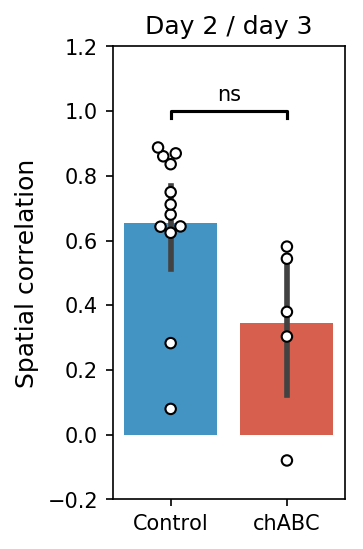

In [35]:
plt.figure(figsize=(2, 4))

plt.title("Day 2 / day 3")
ax = sns.barplot('chabc', 'day2_vs_day3', data=multiday_results, palette=[control_novel_color, chabc_novel_color], saturation=1)
sns.swarmplot('chabc', 'day2_vs_day3', data=multiday_results, edgecolor='black', linewidth=1, color="white")
ax.set_xticklabels(["Control", "chABC"])
ax.set_ylabel("Spatial correlation", fontsize=12)
ax.set_xlabel("")

Zvalue, pvalue = scipy.stats.ranksums(multiday_results.query('chabc')['day2_vs_day3'],
                                      multiday_results.query('not chabc')['day2_vs_day3'])
print(Zvalue, pvalue)

plot_significance(pvalue, 1.0, 0.02)

plt.ylim(-0.2, 1.2)

plt.savefig(output_path / "figures" / "day2_vs_day3.pdf", bbox_inches='tight')
plt.savefig(output_path / "figures" / "day2_vs_day3.png", bbox_inches='tight')

In [42]:
columns = [
    'familiar_i_vs_familiar_ii',
    'diff_familiar_first_vs_second',
    'familiar_i_first_vs_second',
    'familiar_ii_first_vs_second'
]

multiday_columns = [
    'day1_vs_day2',
    'day2_vs_day3'
]



def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


summary_results = pd.DataFrame()

summary_results['Control'] = results.query('not chabc')[columns].agg(summarize)
summary_results['chABC'] = results.query('chabc')[columns].agg(summarize)

summary_multiday_results = pd.DataFrame()

summary_multiday_results['Control'] = multiday_results.query('not chabc')[multiday_columns].agg(summarize)
summary_multiday_results['chABC'] = multiday_results.query('chabc')[multiday_columns].agg(summarize)



def MWU(column, df):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df.query('not chabc')[column].dropna(), 
        df.query('chabc')[column].dropna(),
        alternative='two-sided')
    
    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, df):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df.query('not chabc')[column].dropna(), 
        df.query('chabc')[column].dropna(), statistic=np.median)
    
    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


summary_results['MWU'] = list(map(lambda x: MWU(x, results), columns))
summary_results['PRS'] = list(map(lambda x: PRS(x, results), columns))


summary_multiday_results['MWU'] = list(map(lambda x: MWU(x, multiday_results), multiday_columns))
summary_multiday_results['PRS'] = list(map(lambda x: PRS(x, multiday_results), multiday_columns))

nice_table = summary_results.append(summary_multiday_results)

nice_table.to_latex(output_path / "statistics" / "chabc_control_statistics.tex")
nice_table.to_csv(output_path / "statistics" / "chabc_control_statistics.csv")
nice_table

,Control,chABC,MWU,PRS
familiar_i_vs_familiar_ii,0.63 ± 0.08 (16),0.57 ± 0.08 (16),"152.00, 0.376","0.08, 0.162"
diff_familiar_first_vs_second,0.01 ± 0.04 (16),-0.12 ± 0.05 (16),"178.00, 0.062","0.13, 0.229"
familiar_i_first_vs_second,0.66 ± 0.03 (16),0.63 ± 0.03 (16),"139.00, 0.692","0.02, 0.629"
familiar_ii_first_vs_second,0.67 ± 0.04 (16),0.51 ± 0.05 (16),"191.00, 0.018","0.19, 0.016"
day1_vs_day2,0.67 ± 0.09 (12),0.35 ± 0.09 (11),"113.00, 0.004","0.35, 0.006"
day2_vs_day3,0.66 ± 0.07 (12),0.35 ± 0.12 (5),"52.00, 0.023","0.32, 0.052"


In [43]:
columns = [
    'familiar_i_first_vs_second',
    'novel_i_first_vs_second'
]

states = [
    'chabc',
    'not chabc'
]

def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


nice_table = pd.DataFrame()

nice_table['Control'] = results.query('not chabc')[columns].agg(summarize)
nice_table['chABC'] = results.query('chabc')[columns].agg(summarize)


def state_MWU(state, df, col1, col2):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df.query(state)[col1].dropna(), 
        df.query(state)[col2].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def state_PRS(state, df, col1, col2):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df.query(state)[col1].dropna(), 
        df.query(state)[col2].dropna(), statistic=np.median)
    
    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)

nice_table.loc['PRS', 'Control'] = state_PRS('not chabc', results, *columns)
nice_table.loc['PRS', 'chABC'] = state_PRS('chabc', results, *columns)

nice_table.loc['MWU', 'Control'] = state_MWU('not chabc', results, *columns)
nice_table.loc['MWU', 'chABC'] = state_MWU('chabc', results, *columns)


nice_table.to_latex(output_path / "statistics" / "internal_statistics.tex")
nice_table.to_csv(output_path / "statistics" / "internal_statistics.csv")
nice_table

,Control,chABC
familiar_i_first_vs_second,0.66 ± 0.03 (16),0.63 ± 0.03 (16)
novel_i_first_vs_second,0.59 ± 0.03 (16),0.45 ± 0.06 (16)
PRS,"0.13, 0.070","0.21, 0.017"
MWU,"174.00, 0.086","193.00, 0.015"


# Store results in Expipe

In [44]:
action = project.require_action("calculate_spatial_correlation")

In [45]:
outdata = {
    "figures": "figures",
    "results": "results.csv"
}

for key, value in outdata.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [46]:
pnnmec.registration.store_notebook(action, "20_spatial_correlation.ipynb")

In [47]:
action.modules["code_version"] = vc.create_code_version_module()
action.modules["data_version"] = vc.create_data_version_module(project_path)